# Geo KG Completion testing


## About

This is a simple test notebook to explore approachs to associating geometries in the OIH graph with named ocean regions.
From Marine Regions (https://www.marineregions.org/) we downloaded the IHO Sea Areas dataset.  This is a shapefile that is converted to WKT and loaded into a geopandas dataframe.   
 
 
We then create a few points to compare against this.   In this test we are only comparing points to the polygons.  So this is what is called a "point in polygon" test.   Later revisions to this could do polygon intersection or other tests.  This is only a proof of concept notebook.

We then generate a new dataframe based on the matches.   These matches could then be fed back into the graph as a sort of "Knowledge Graph Completion" workflow.  Alternatively we can do gepsparql calls based on the sea WKT strings and do the search in the geosparql aware triple store.  

## References
* https://geopandas.org/docs/user_guide/set_operations.html
* https://geopandas.org/docs/user_guide/geocoding.html
* https://medium.com/analytics-vidhya/point-in-polygon-analysis-using-python-geopandas-27ea67888bff

In [1]:
#@title
# !apt-get install libproj-dev proj-data proj-bin
# !apt-get install libgeos-dev
!pip install -q cython
!pip install -q cartopy
!pip install -q SPARQLWrapper
!pip install -q rdflib
!pip install -q geopandas
!pip install -q contextily==1.0rc2
!pip install -q rtree
!pip install -q pygeos

  ERROR: Command errored out with exit status 1:
   command: /usr/bin/python3 /usr/lib/python3.9/site-packages/pip/_vendor/pep517/_in_process.py build_wheel /tmp/tmpf2_kik3l
       cwd: /tmp/pip-install-zrbv9z0o/cartopy
  Complete output (236 lines):
  setup.py:117: UserWarning: Unable to determine GEOS version. Ensure you have 3.3.3 or later installed, or installation may fail.
    warnings.warn(
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.9
  creating build/lib.linux-x86_64-3.9/cartopy
  copying lib/cartopy/vector_transform.py -> build/lib.linux-x86_64-3.9/cartopy
  copying lib/cartopy/util.py -> build/lib.linux-x86_64-3.9/cartopy
  copying lib/cartopy/img_transform.py -> build/lib.linux-x86_64-3.9/cartopy
  copying lib/cartopy/crs.py -> build/lib.linux-x86_64-3.9/cartopy
  copying lib/cartopy/_version.py -> build/lib.linux-x86_64-3.9/cartopy
  copying lib/cartopy/_epsg.py -> build/lib.linux-x86_64-3.9/cartopy
  copyin

In [2]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import numpy as np
import json
import geopandas
import matplotlib.pyplot as plt
import shapely

#dbsparql = "http://dbpedia.org/sparql"
# ufokn = "http://graph.collaborium.io/blazegraph/namespace/oihdev/sparql"

/home/fils/.local/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
# Point in Polygon function from the cited Vidhya reference.  A few small changes
# to align with our dataframes here

def get_pip (gdf, regions):
    r_list = list(regions.NAME)
    #create empty dataframe
    df = pd.DataFrame().reindex_like(gdf).dropna()
    for r in r_list:
        #get geometry for specific region
        pol = (regions.loc[regions.NAME==r])
        pol.reset_index(drop = True, inplace = True)
        #identify those records from gdf that are intersecting with the region polygon
        pip_mask = gdf.within(pol.loc[0, 'WKT'])
        #filter gdf to keep only the intersecting records
        pip_data = gdf.loc[pip_mask].copy()
        #create a new column and assign the region name as the value
        pip_data['region']= r
        #append region data to empty dataframe
        df = df.append(pip_data)
    #checking there are no more than one region assigned to an event    
    print('Original dataframe count=',len(gdf),'\nNew dataframe count=', len(df))
    if df.loc[df.id.duplicated() == True].shape[0] > 0:
        print("There are id's with more than one region")
    #checking all events have a region
    elif gdf.loc[~gdf.id.isin(df.id)].shape[0] > 0:
        print("There are id's without an assigned region")
    else:
        print("No discrepancies in results!")
    df.reset_index(inplace=True, drop=True)
    df = df.drop(columns='geometry')
    return df

In [4]:
# load CSV into pandas that holds the WKT strings for the world seas dataset
df = pd.read_csv('./World_Seas_IHO_v3.csv')  
# df.head(2)

In [5]:
# convert the WKT strings to WKT geometry
from shapely import wkt
df['WKT'] = df['WKT'].apply(wkt.loads)

In [6]:
# Load and plot the ocean regions
import contextily as ctx

# Make geopandas from df
gdf = geopandas.GeoDataFrame(df, geometry='WKT', crs={"init": "epsg:3857"}) # contextily requires 3875?
# gdf.head(2)

/home/fils/.local/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

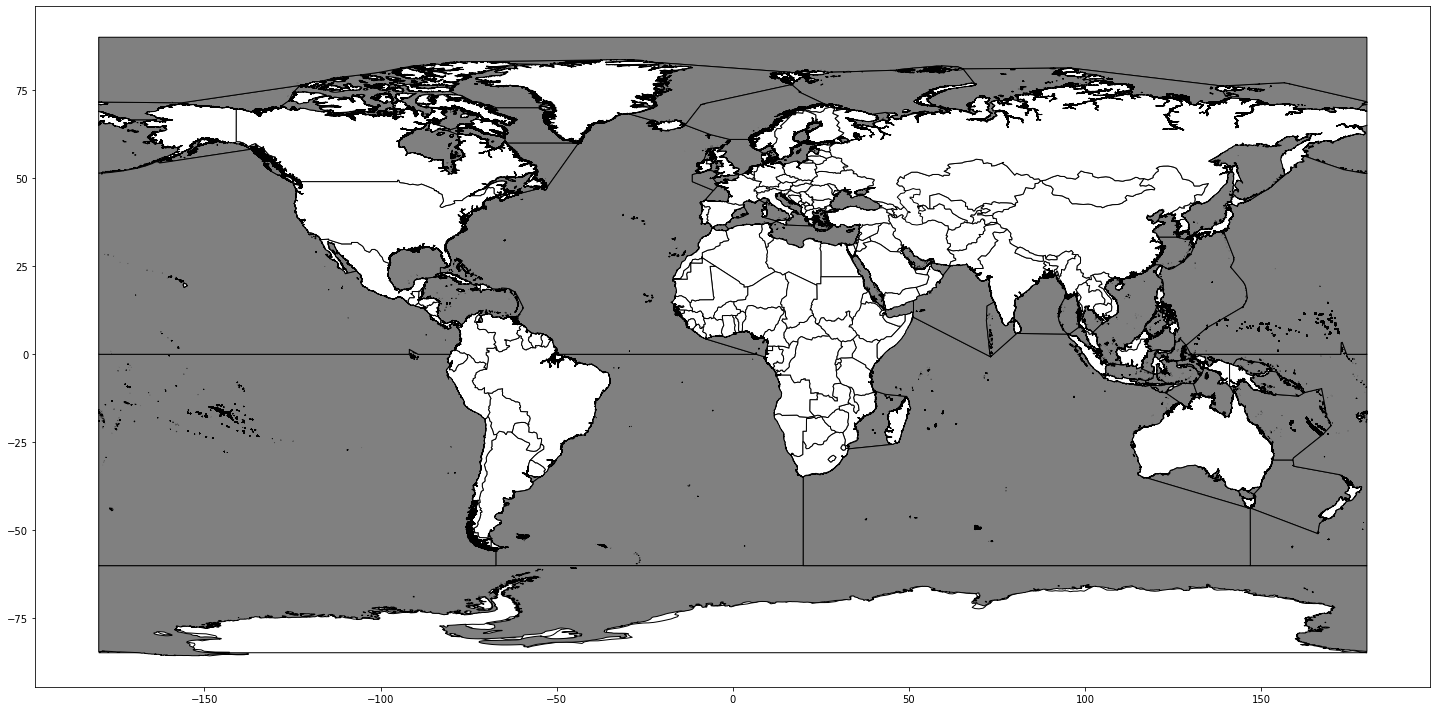

In [7]:
# Make geopandas from GeoJSON of the world for plot
url = "https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json"
dftx = geopandas.read_file(url)

# plot
ax = dftx.plot(color='white', edgecolor='black', figsize=(25,15))
gdf.plot(ax=ax, edgecolor='black', color='grey')


In [8]:
# Make test datarame with some lat long pairs to test
# Later these will come from SPARQL calls to the OIH graph

df = pd.DataFrame({ 'Latitude': [38, -1,  -37,  -22,14],
                   'Longitude': [-146, 0, 129,  37,85], 
                   'id':["Off US West Coast","Atlantic","South of Australia", "Africa","Near India"]})

testdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))

In [9]:
# Call the function and do pip calculations
eq_df = get_pip(testdf, gdf)


Original dataframe count= 5 
New dataframe count= 5
No discrepancies in results!


## Conclusion

The generated dataframe holds the matches of the test Lat Long pairs to the named seas from the reference shape file.
These results couild be fed back into the graph as keywords or items from a known list of terms for more explicate relation mapping.

Specifically,  someting like https://schema.org/DefinedTerm where the property https://schema.org/DefinedTermSet would point back to the Marine Regions source documents and URL.   Similarly these resources could be connected up to WikiData in a similar manner.   

```
        {
                "@type": "DefinedTermSet",
                "@id": "http://geonetwork.vliz.be/geonetwork/srv/eng/catalog.search#/metadata/f4cfa278-730f-4646-b6cc-a3dceaa3a1e5",
                "name": "IHO Sea Areas"
        },
        {
                "@type": "DefinedTerm",
                "name": "Bay of Bengal",
                "description": "IHO Sea Area Bay of Bengal",
                "inDefinedTermSet": "http://geonetwork.vliz.be/geonetwork/srv/eng/catalog.search#/metadata/f4cfa278-730f-4646-b6cc-a3dceaa3a1e5"
        },
```

For reference the WikiData resource is: https://www.wikidata.org/wiki/Q38684 which is an instance of "body of water".  So leveraging this type and the IHO names should allow relatively reliable link detection.   Leveraging the top level Thing class in schema.org we would be looking at a simple

```
    "sameAs": "https://www.wikidata.org/wiki/Q38684",
```

in the DefinedTerm type.

In the final listing below the "id" is the just the random string I associated with the test lat longs. I used a simple online map to just pick some random locations and gave them names.   The "region" cames from the offical Marine Regions file.  

In [10]:
eq_df.head()

,Latitude,Longitude,id,region
0,-37.0,129.0,South of Australia,Great Australian Bight
1,-22.0,37.0,Africa,Mozambique Channel
2,-1.0,0.0,Atlantic,South Atlantic Ocean
3,14.0,85.0,Near India,Bay of Bengal
4,38.0,-146.0,Off US West Coast,North Pacific Ocean
